# Jupyter Ascending: Using Jupyter in Infosec

## Part 1: Log Analysis

In [1]:
# Let's start by importing helpful modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Now, let's import some files
with open("www1/access.log") as f:
    access_log = f.readlines()

with open("www1/secure.log") as f:
    secure_log = f.readlines()

In [3]:
# Let's investigate what a log line looks like:
print(access_log[0])
print(secure_log[0])

209.160.24.63 - - [11/Mar/2020:18:22:16] "GET /product.screen?productId=WC-SH-A02&JSESSIONID=SD0SL6FF7ADFF4953 HTTP 1.1" 200 3878 "http://www.google.com" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/536.5 (KHTML, like Gecko) Chrome/19.0.1084.46 Safari/536.5" 349

Thu Mar 11 2020 00:15:02 www1 sshd[4747]: Failed password for invalid user jabber from 118.142.68.222 port 3187 ssh2



### Breaking down the log

Unfortunately, logfiles are just plaintext, so if we want to structure the data, it's up to us. There are many approaches to doing this, but I find the easiest to be building up the [pandas](https://pandas.pydata.org/) DataFrame column by column. It'll become clear as we go.

In [4]:
access_df = pd.DataFrame({"raw": access_log})
secure_df = pd.DataFrame({"raw": secure_log})

In [5]:
# Check out the shape of our DataFrames
print(access_df.shape)
print(secure_df.shape)

(13628, 1)
(10593, 1)


Okay, so not an exact match for number of rows, but pretty close! The more data the better, especially as we try to correlate the security log with the access log.

In [6]:
# Take a peek at the first 5 rows
access_df.head()

,raw
0,"209.160.24.63 - - [11/Mar/2020:18:22:16] ""GET ..."
1,"209.160.24.63 - - [11/Mar/2020:18:22:16] ""GET ..."
2,"209.160.24.63 - - [11/Mar/2020:18:22:17] ""GET ..."
3,"209.160.24.63 - - [11/Mar/2020:18:22:19] ""POST..."
4,"209.160.24.63 - - [11/Mar/2020:18:22:20] ""GET ..."


In [7]:
secure_df.head()

,raw
0,Thu Mar 11 2020 00:15:02 www1 sshd[4747]: Fail...
1,Thu Mar 11 2020 00:15:02 www1 sshd[4111]: Fail...
2,Thu Mar 11 2020 00:15:02 www1 sshd[5359]: Fail...
3,Thu Mar 11 2020 00:15:02 www1 su: pam_unix(su:...
4,Thu Mar 11 2020 00:15:02 www1 sshd[2660]: Fail...


So, obviously not _that_ helpful. But pandas has some handy built-in methods for extracting information from columns. So let's start there. My first target is the IP address. Because they're all the same length and at the start of the string, Python makes that easy enough.

In [8]:
# I can access columns using bracket syntax
access_df["raw"]

0        209.160.24.63 - - [11/Mar/2020:18:22:16] "GET ...
1        209.160.24.63 - - [11/Mar/2020:18:22:16] "GET ...
2        209.160.24.63 - - [11/Mar/2020:18:22:17] "GET ...
3        209.160.24.63 - - [11/Mar/2020:18:22:19] "POST...
4        209.160.24.63 - - [11/Mar/2020:18:22:20] "GET ...
                               ...                        
13623    182.236.164.11 - - [18/Mar/2020:18:20:53] "GET...
13624    182.236.164.11 - - [18/Mar/2020:18:20:53] "GET...
13625    182.236.164.11 - - [18/Mar/2020:18:20:54] "GET...
13626    182.236.164.11 - - [18/Mar/2020:18:20:55] "POS...
13627    182.236.164.11 - - [18/Mar/2020:18:20:56] "GET...
Name: raw, Length: 13628, dtype: object

In [9]:
# I can also use the .loc method
secure_df.loc[:,"raw"] # The : would be where index references go

0        Thu Mar 11 2020 00:15:02 www1 sshd[4747]: Fail...
1        Thu Mar 11 2020 00:15:02 www1 sshd[4111]: Fail...
2        Thu Mar 11 2020 00:15:02 www1 sshd[5359]: Fail...
3        Thu Mar 11 2020 00:15:02 www1 su: pam_unix(su:...
4        Thu Mar 11 2020 00:15:02 www1 sshd[2660]: Fail...
                               ...                        
10588    Thu Mar 18 2020 00:15:02 www1 sshd[1089]: Fail...
10589    Thu Mar 18 2020 00:15:02 www1 su: pam_unix(su:...
10590    Thu Mar 18 2020 00:15:02 www1 sshd[4225]: Fail...
10591    Thu Mar 18 2020 00:15:02 www1 sshd[5034]: Fail...
10592    Thu Mar 18 2020 00:15:02 www1 sshd[1654]: Fail...
Name: raw, Length: 10593, dtype: object

In [10]:
# Now, check out how I can use the .str method on a Series (column) to perform operations across the Series
access_df["raw"].str[0:13]

0        209.160.24.63
1        209.160.24.63
2        209.160.24.63
3        209.160.24.63
4        209.160.24.63
             ...      
13623    182.236.164.1
13624    182.236.164.1
13625    182.236.164.1
13626    182.236.164.1
13627    182.236.164.1
Name: raw, Length: 13628, dtype: object

That's cool, but unfortunately I have no way of guaranteeing the length of the last octet. Looks like I'm gonna have to use...

...

**_regular expressions_**

In [11]:
access_df["ip"] = access_df["raw"].str.extract(r"(\d+\.\d+\.\d+\.\d+)")

In [12]:
secure_df["ip"] = secure_df["raw"].str.extract(r"(\d+\.\d+\.\d+\.\d+)")

In [13]:
access_df.head()

,raw,ip
0,"209.160.24.63 - - [11/Mar/2020:18:22:16] ""GET ...",209.160.24.63
1,"209.160.24.63 - - [11/Mar/2020:18:22:16] ""GET ...",209.160.24.63
2,"209.160.24.63 - - [11/Mar/2020:18:22:17] ""GET ...",209.160.24.63
3,"209.160.24.63 - - [11/Mar/2020:18:22:19] ""POST...",209.160.24.63
4,"209.160.24.63 - - [11/Mar/2020:18:22:20] ""GET ...",209.160.24.63


Nice! We have IPs. What else do I want. What about...timestamps?

In [14]:
# Have to use regex for access
access_df["timestamp"] = access_df["raw"].str.extract(r"\[(.+)\]")

In [15]:
# But secure has a consistent-length string right up front
secure_df["timestamp"] = secure_df["raw"].str[0:24]

Timestamps acquired! We still have some work to do before we convert them properly to datetimes, but for now, let's go after some other low-hanging fruit.

In [16]:
access_df["request"] = access_df["raw"].str.extract(r"\"(\w+) \/")
access_df["response"] = access_df["raw"].str.extract(r"\" (\d+) ")
access_df["path"] = access_df["raw"].str.extract(r"\"\w+(\/.+) HTTP")
access_df["url"] = access_df["raw"].str.extract(r"\d+ \"(https?:\/\/\w*\.?\w+\.\w+)")

In [17]:
secure_df["user"] = secure_df["raw"].str.extract(r"user (\w+)")
secure_df["port"] = secure_df["raw"].str.extract(r"port (\d+)")
secure_df["failure"] = secure_df["raw"].str.contains("Failed")

In [18]:
pd.set_option("display.max_colwidth", None) # Make stuff easier to view

## Timestamps and Pandas Indices

In Pandas, an Index is a way of referencing and sorting rows of tabular data. Unlike regular row numbers, indices can have special data types, along with associated methods. Indices can also be multi-level, as when we group by, say, date _and_ user. DataFrames kick off with a simple Integer Index, but we can turn our `timestamp` column into a `DateTimeIndex`, which will allow us to sort our data chronologically.

In [19]:
# Use pd.to_datetime to turn our timestamp into a real datetimeobject
# 11 Mar 2020:18:22:16
access_datetimes = pd.to_datetime(access_df["timestamp"].infer_objects(), format="%d/%b/%Y:%H:%M:%S")

In [20]:
# The secure log datetimes are sane enough we don't have to provide a format
secure_datetimes = pd.to_datetime(secure_df["timestamp"].infer_objects())

In [21]:
# Now, we set the dataframes index
access_df.set_index(access_datetimes, inplace=True)
secure_df.set_index(secure_datetimes, inplace=True)

In [22]:
# Look at the difference!
access_df.head()

,raw,ip,timestamp,request,response,path,url
timestamp,,,,,,,
2020-03-11 18:22:16,"209.160.24.63 - - [11/Mar/2020:18:22:16] ""GET /product.screen?productId=WC-SH-A02&JSESSIONID=SD0SL6FF7ADFF4953 HTTP 1.1"" 200 3878 ""http://www.google.com"" ""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/536.5 (KHTML, like Gecko) Chrome/19.0.1084.46 Safari/536.5"" 349\n",209.160.24.63,11/Mar/2020:18:22:16,GET,200,NaN,http://www.google.com
2020-03-11 18:22:16,"209.160.24.63 - - [11/Mar/2020:18:22:16] ""GET /oldlink?itemId=EST-6&JSESSIONID=SD0SL6FF7ADFF4953 HTTP 1.1"" 200 1748 ""http://www.buttercupgames.com/oldlink?itemId=EST-6"" ""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/536.5 (KHTML, like Gecko) Chrome/19.0.1084.46 Safari/536.5"" 731\n",209.160.24.63,11/Mar/2020:18:22:16,GET,200,NaN,http://www.buttercupgames.com
2020-03-11 18:22:17,"209.160.24.63 - - [11/Mar/2020:18:22:17] ""GET /product.screen?productId=BS-AG-G09&JSESSIONID=SD0SL6FF7ADFF4953 HTTP 1.1"" 200 2550 ""http://www.buttercupgames.com/product.screen?productId=BS-AG-G09"" ""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/536.5 (KHTML, like Gecko) Chrome/19.0.1084.46 Safari/536.5"" 422\n",209.160.24.63,11/Mar/2020:18:22:17,GET,200,NaN,http://www.buttercupgames.com
2020-03-11 18:22:19,"209.160.24.63 - - [11/Mar/2020:18:22:19] ""POST /category.screen?categoryId=STRATEGY&JSESSIONID=SD0SL6FF7ADFF4953 HTTP 1.1"" 200 407 ""http://www.buttercupgames.com/cart.do?action=remove&itemId=EST-7&productId=PZ-SG-G05"" ""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/536.5 (KHTML, like Gecko) Chrome/19.0.1084.46 Safari/536.5"" 211\n",209.160.24.63,11/Mar/2020:18:22:19,POST,200,NaN,http://www.buttercupgames.com
2020-03-11 18:22:20,"209.160.24.63 - - [11/Mar/2020:18:22:20] ""GET /product.screen?productId=FS-SG-G03&JSESSIONID=SD0SL6FF7ADFF4953 HTTP 1.1"" 200 2047 ""http://www.buttercupgames.com/category.screen?categoryId=STRATEGY"" ""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/536.5 (KHTML, like Gecko) Chrome/19.0.1084.46 Safari/536.5"" 487\n",209.160.24.63,11/Mar/2020:18:22:20,GET,200,NaN,http://www.buttercupgames.com


## Data Analysis

_Now_ we can have some fun. When reviewing logs, the first question might be event rate. A rate requires a count per...something. Let's do per minute just to get started.

In [23]:
secure_df.groupby(secure_df.index.minute).count()

,raw,ip,timestamp,user,port,failure
timestamp,,,,,,
15,10593,9402,10593,7296,9420,10593


In [24]:
access_df.groupby(access_df.index.minute).count().head()

,raw,ip,timestamp,request,response,path,url
timestamp,,,,,,,
0,259,259,259,259,259,0,259
1,167,167,167,167,167,0,167
2,269,269,269,268,269,0,269
3,128,128,128,128,128,0,128
4,224,224,224,223,224,0,224


Uh, okay, that was less than helpful. What about grouping by hour, minute, _and_ minute?

In [25]:
secure_df.groupby([secure_df.index.hour, secure_df.index.minute, secure_df.index.second]).count()

,,,raw,ip,timestamp,user,port,failure
timestamp,timestamp,timestamp,,,,,,
0,15,2,10593,9402,10593,7296,9420,10593


In [26]:
access_df.groupby([access_df.index.hour, access_df.index.minute, access_df.index.second]).count()

raw  ip  timestamp  request  response  path  \
timestamp timestamp timestamp                                                
0         0         37           2   2          2        2         2     0   
                    38           1   1          1        1         1     0   
          1         16           1   1          1        1         1     0   
                    17           2   2          2        2         2     0   
                    18           1   1          1        1         1     0   
...                            ...  ..        ...      ...       ...   ...   
23        58        58           1   1          1        1         1     0   
                    59           1   1          1        1         1     0   
          59        0            2   2          2        2         2     0   
                    1            1   1          1        1         1     0   
                    56           1   1          1        1         1     0   

                               url  
timestamp timestamp timestamp       
0         0         37           2  
                    38           1  
          1         16           1  
                    17           2  
                    18           1  
...                            ...  
23        58        58           1  
                    59           1  
          59        0            2  
                    1            1  
                    56           1  

[8441 rows x 7 columns]

#### Tabular vs. Visual Analysis

Sometimes tabular data is revealing...sometimes not. Often for rates, we need a real visualization. We have several options for creating plots in Jupyter, although I primarily use the venerable Pyplot library, since it's built in to Pandas.

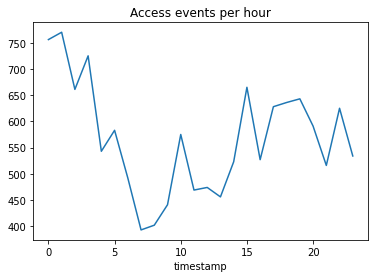

In [27]:
access_df.groupby(access_df.index.hour).count()["raw"].plot.line(title="Access events per hour")

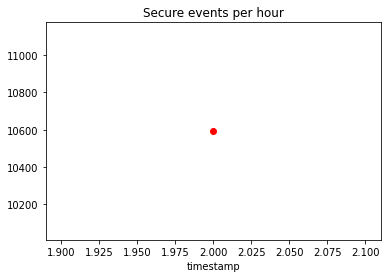

In [28]:
secure_df.groupby(secure_df.index.second).count()["raw"].plot.line(title="Secure events per hour", style="ro")

### Categorical data

Sometimes we want to review categorical data. Let's look at events by IP. I'll show you the built-in pie chart, as well as the handy Seaborn `barplot()`.

In [31]:
# First let's make sure we have a shape that makes sense.
top_access_ips = access_df.groupby("ip").count().sort_values(by="raw", ascending=False)

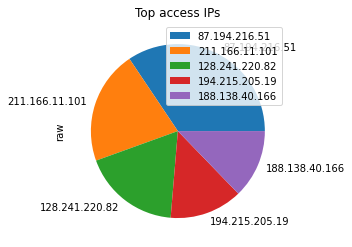

In [37]:
# Get the top 5 IPs for our Pie chart
top_access_ips.head().plot.pie(y="raw", title="Top access IPs")

Let's see what's up with logon failures. First we'll examine how many users we're talking about.

In [42]:
failed_users = secure_df[secure_df["failure"] == True].groupby("user")

In [45]:
failed_users.count()

,raw,ip,timestamp,port,failure
user,,,,,
abc,23,23,23,23,23
adm,23,23,23,23,23
admin,257,257,257,257,257
administrator,254,254,254,254,254
agushto,19,19,19,19,19
...,...,...,...,...,...
web002,18,18,18,18,18
whois,95,95,95,95,95
workshop,66,66,66,66,66


115 rows?! Too many for a chart. Let's get the top 10.

In [48]:
top_failures = failed_users.count().sort_values(by="failure", ascending=False).head(10)

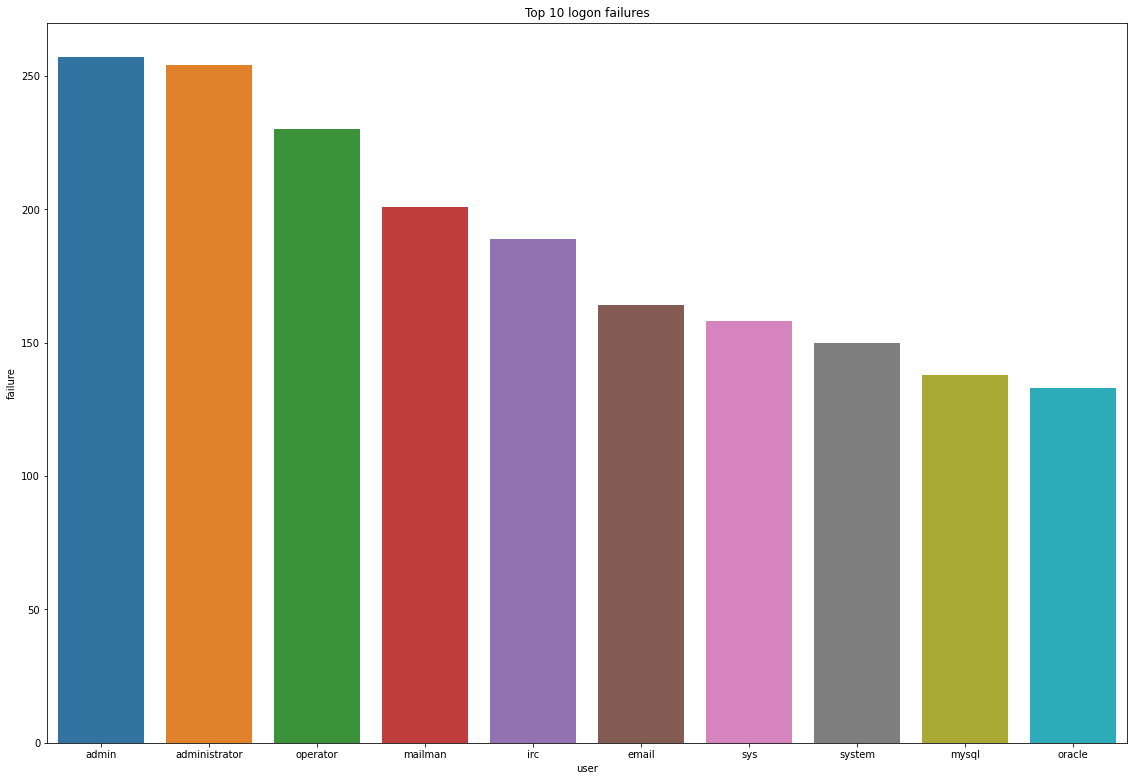

In [51]:
fig = plt.figure(2,figsize=(15,10))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Top 10 logon failures")
sns.barplot(x=top_failures.index, y=top_failures["failure"], ax=ax)

This looks...suspicious. We could, if we wanted, go further and analyze web requests at that time to see other anomalous activity. We might also group by user _and_ IP to see if a pattern is established there.

### Threat Hunting

One last thought on Jupyter and Infosec. Because we have access to Python's `requests` library, we can tie into any API we choose and correlate data with data from an API—for example, VirusTotal, Talos, or other Threat Intel platforms. 